In [15]:
%store -r df
%store -r EA_df
%store -r X_1
%store -r EA_vol_df_garch
%store -r EA_2y_garch_vols
%store -r EA_10Y_mth_yields
%store -r HICP__
%store -r GDP__

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [17]:
df_2_10 = df[["EA_2Y", "EA_10Y"]]
df_2_10.reset_index(inplace=True)
df_2_10.set_index('Security', inplace=True)
df_2_10.index = pd.to_datetime(df_2_10.index)
df_2_10.reset_index(inplace=True)
df_2_10_no_dates = df_2_10.drop('Security', axis = 1)
df_2_10_no_dates = df_2_10_no_dates/100

Explained variance by each component: [0.96292943 0.03707057]


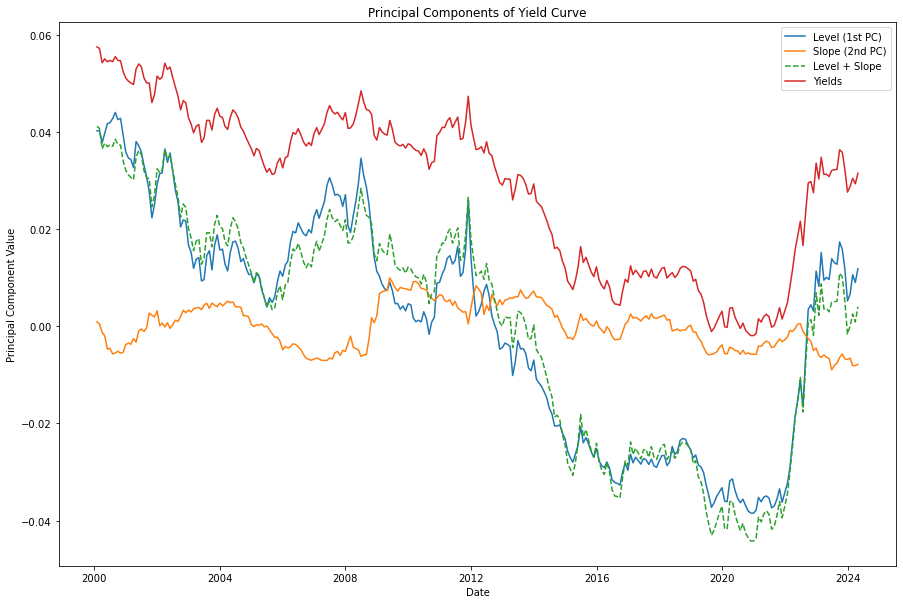

Initial level (X0): -3.0417069167812506e-18
Initial slope (X0): 2.0911735052871098e-18
Initial level variance (X0): 0.0005480207963663772
Initial slope variance (X0): 2.1097543572868867e-05


In [42]:
yield_data = df_2_10_no_dates

# Standardize the data
scaler = StandardScaler()
yield_data_scaled = yield_data

# Perform PCA
pca = PCA(n_components=2)  # We need the first two components for level and slope
pca.fit(yield_data_scaled)
principal_components = pca.transform(yield_data_scaled)

# Extract the first two principal components
level = principal_components[:, 0]
slope = principal_components[:, 1]

# Print the explained variance to understand the importance of each component
print("Explained variance by each component:", pca.explained_variance_ratio_)

dates_yields = pd.date_range(start="2000-01-31", end="2024-04-30", freq='M')

# Plot the principal components to visualize
plt.figure(figsize=(15, 10))
plt.plot(dates_yields, level, label='Level (1st PC)')
plt.plot(dates_yields, slope, label='Slope (2nd PC)')
plt.plot(dates_yields, level + slope, label='Level + Slope', ls='--')
plt.plot(dates_yields, yield_data['EA_10Y'], label='Yields')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.title('Principal Components of Yield Curve')
plt.show()

# Set initial values for X0 based on the mean of the principal components
X0_level = level.mean()
X0_slope = slope.mean()

X0_level_var = level.var()
X0_slope_var = slope.var()
print("Initial level (X0):", X0_level)
print("Initial slope (X0):", X0_slope)
print("Initial level variance (X0):", X0_level_var)
print("Initial slope variance (X0):", X0_slope_var)

In [41]:
level - (level + (slope * yield_data['EA_10Y']))

0     -0.000052
1     -0.000028
2      0.000068
3      0.000109
4      0.000257
         ...   
287    0.000189
288    0.000189
289    0.000247
290    0.000238
291    0.000247
Name: EA_10Y, Length: 292, dtype: float64

In [19]:
%store level
%store slope

Stored 'level' (ndarray)
Stored 'slope' (ndarray)


In [20]:
# Calculate the initial level from the original data
X0_level = yield_data.mean().mean()
X0_level_var_ = yield_data.mean().var()

# Calculate the initial slope from the first principal component loadings
first_pc_loadings = pca.components_[0]
X0_slope = np.mean(first_pc_loadings)
X0_slope_var_ = np.var(first_pc_loadings)
print("Initial level (X0):", X0_level, "Var: ", X0_level_var_)
print("Initial slope (X0):", X0_slope, "Var: ", X0_slope_var_)

Initial level (X0): 0.02318467340753426 Var:  6.566177611027625e-05
Initial slope (X0): 0.7069886886425497 Var:  0.00016699413148793676


In [21]:
EA_vol_df_garch = EA_vol_df_garch[0:288]
EA_vol_df_garch.set_index('Date', inplace=True)
EA_vol_df_garch.index = pd.to_datetime(EA_vol_df_garch.index)
EA_vol_df_garch

,GARCH Volatility
Date,
2000-01-31,0.000528
2000-02-29,0.000649
2000-03-31,0.000432
2000-04-30,0.000991
2000-05-31,0.001309
...,...
2023-08-31,0.000333
2023-09-30,0.003813
2023-10-31,0.000932


In [22]:
EA_vol_df_garch_04 = EA_vol_df_garch.iloc[56:]
EA_vol_df_garch_04.index = pd.to_datetime(EA_vol_df_garch_04.index)
EA_vol_df_garch_04

,GARCH Volatility
Date,
2004-09-30,0.000733
2004-10-31,0.000322
2004-11-30,0.000178
2004-12-31,0.000725
2005-01-31,0.000323
...,...
2023-08-31,0.000333
2023-09-30,0.003813
2023-10-31,0.000932


In [23]:

EA_2y_garch_vols.index = pd.to_datetime(EA_2y_garch_vols.index)
EA_2y_garch_vols_12_31 = EA_2y_garch_vols[:-6]
EA_2y_garch_vols_12_31

,EA2Y Yield
Date,
2004-09-30,0.000335
2004-10-31,0.000383
2004-11-30,0.000497
2004-12-31,0.000792
2005-01-31,0.000184
...,...
2023-08-31,0.000467
2023-09-30,0.001359
2023-10-31,0.001075


In [24]:
merged_2y_10y = pd.merge(EA_2y_garch_vols_12_31, EA_vol_df_garch_04, on='Date')
merged_2y_10y

,EA2Y Yield,GARCH Volatility
Date,,
2004-09-30,0.000335,0.000733
2004-10-31,0.000383,0.000322
2004-11-30,0.000497,0.000178
2004-12-31,0.000792,0.000725
2005-01-31,0.000184,0.000323
...,...,...
2023-08-31,0.000467,0.000333
2023-09-30,0.001359,0.003813
2023-10-31,0.001075,0.000932


Explained variance by each component: [0.82600046 0.17399954]


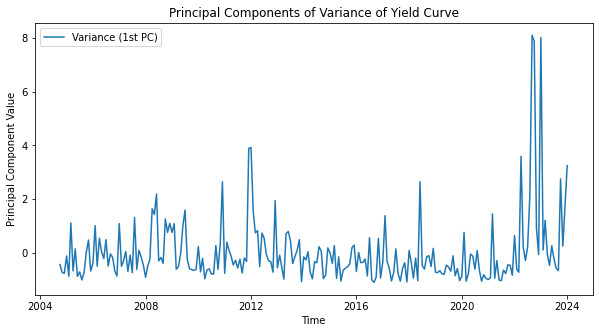

Initial variance (X0): 2.2970131543968756e-17


In [29]:
# Standardize the data
scaler_var = StandardScaler()
var_data_scaled = scaler.fit_transform(merged_2y_10y)

# Perform PCA
pca_var = PCA(n_components=2)  # We need the first two components for level and slope
principal_components_var = pca_var.fit_transform(var_data_scaled)

# Extract the first two principal components
variance = principal_components_var[:,0]
v2 = principal_components[:, 1]

# Print the explained variance to understand the importance of each component
print("Explained variance by each component:", pca_var.explained_variance_ratio_)

# Plot the principal components to visualize
plt.figure(figsize=(10, 5))
plt.plot(merged_2y_10y.index, variance, label='Variance (1st PC)')
#plt.plot(v2, label='Variance (2nd PC)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Principal Component Value')
plt.title('Principal Components of Variance of Yield Curve')
plt.show()

# Set initial values for X0 based on the mean of the principal components
X0_var = np.mean(variance)

print("Initial variance (X0):", X0_var)

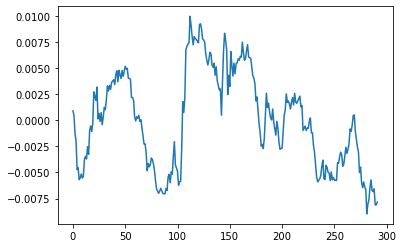

In [30]:
plt.plot(v2, label='Variance (2nd PC)')

In [49]:
# Calculate the initial level from the original data
X0_var2 = merged_2y_10y.mean().mean()

# Calculate the initial slope from the first principal component loadings
first_pc_loadings_var = pca_var.components_[0]
X0_var3 = np.mean(first_pc_loadings_var)
print("Initial var2 (X0):", X0_var2)
print("Initial var3 (X0):", X0_var3)

Initial var2 (X0): 0.0008337694390724525
Initial var3 (X0): 0.7071067811865475
